<a href="https://colab.research.google.com/github/kiran9846/API_News_Website/blob/main/Movie_Revenue_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Factors That Affect Box Office Performance


---
# Global Question
---

## What factors drive box office success?

**Research Questions:**
- How does production budget correlate with revenue?
- Do different genres perform differently?
- Does popularity predict revenue?
- Which rating system (Metacritic, IMDB, TMDB) best predicts box office success?

**Data Sources:**
- **TMDB Movies Dataset (1M):** Budget, revenue, genres, popularity, TMDB ratings
- **IMDB Top 1000:** IMDB ratings, Metacritic scores

**Methods:** We merge datasets by title, adjust for inflation (2024 USD), and calculate Pearson correlations with 95% confidence intervals.

**Assumptions & Challenges:**
- Merging the data sets reduced sample size significantly
- Many films lack complete financial data
- Inflation adjustment required across ~100 years

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [ ]:
# Load and merge datasets
all_movies = pd.read_csv("TMDB_movie_dataset_v11.csv")
top_movies = pd.read_csv("imdb_top_1000.csv")

# Normalize and merge
all_movies['title'] = all_movies['title'].str.strip().str.lower()
top_movies['Series_Title'] = top_movies['Series_Title'].str.strip().str.lower()
all_movies_unique = all_movies.sort_values('popularity', ascending=False).drop_duplicates('title')
top_movies_unique = top_movies.drop_duplicates('Series_Title')

merged_movies = all_movies_unique.merge(
    top_movies_unique, how='right', left_on='title', right_on='Series_Title'
).drop_duplicates('Series_Title').head(1000)

# Clean revenue
merged_movies['revenue'] = pd.to_numeric(merged_movies['revenue'], errors='coerce')
merged_movies = merged_movies[merged_movies['revenue'] > 0]

print(f"Movies with revenue: {len(merged_movies)}")

Movies with revenue: 692


In [ ]:
# Inflation adjustment using CPI
merged_movies['release_year'] = pd.to_datetime(merged_movies['release_date'], errors='coerce').dt.year

cpi_data = {
    1920: 20.0, 1930: 16.7, 1940: 14.0, 1950: 24.1, 1960: 29.6, 1970: 38.8,
    1980: 82.4, 1990: 130.7, 2000: 172.2, 2010: 218.1, 2020: 258.8, 2024: 314.0
}
for year in range(1921, 2024):
    if year not in cpi_data:
        cpi_data[year] = np.interp(year, list(cpi_data.keys()), list(cpi_data.values()))

cpi_df = pd.DataFrame(list(cpi_data.items()), columns=['year', 'cpi'])
merged_movies = merged_movies.merge(cpi_df, left_on='release_year', right_on='year', how='left')
merged_movies['revenue_adjusted'] = merged_movies['revenue'] * (314.0 / merged_movies['cpi'])

merged_movies['Genre'] = merged_movies['Genre'].combine_first(merged_movies['genres'])
merged_movies['budget'] = pd.to_numeric(merged_movies['budget'], errors='coerce')
merged_movies['Meta_score'] = pd.to_numeric(merged_movies['Meta_score'], errors='coerce')
merged_movies['IMDB_Rating'] = pd.to_numeric(merged_movies['IMDB_Rating'], errors='coerce')
merged_movies['vote_average'] = pd.to_numeric(merged_movies['vote_average'], errors='coerce')

print(f"Adjusted revenue range: ${merged_movies['revenue_adjusted'].min()/1e6:.1f}M - ${merged_movies['revenue_adjusted'].max()/1e6:.1f}M")

Adjusted revenue range: $0.1M - $46672.3M


In [ ]:
def calc_ci(r, n):
    z = np.arctanh(r)
    se = 1/np.sqrt(n-3)
    return np.tanh(z - 1.96*se), np.tanh(z + 1.96*se)

---
# ITERATION 1
---

---
## QAC 1: Genre Performance
---

### Question
**Do different genres perform differently at the box office?**

**Method:** Explode multi-genre labels, calculate mean revenue per genre, test significance using t-tests.

### Analysis

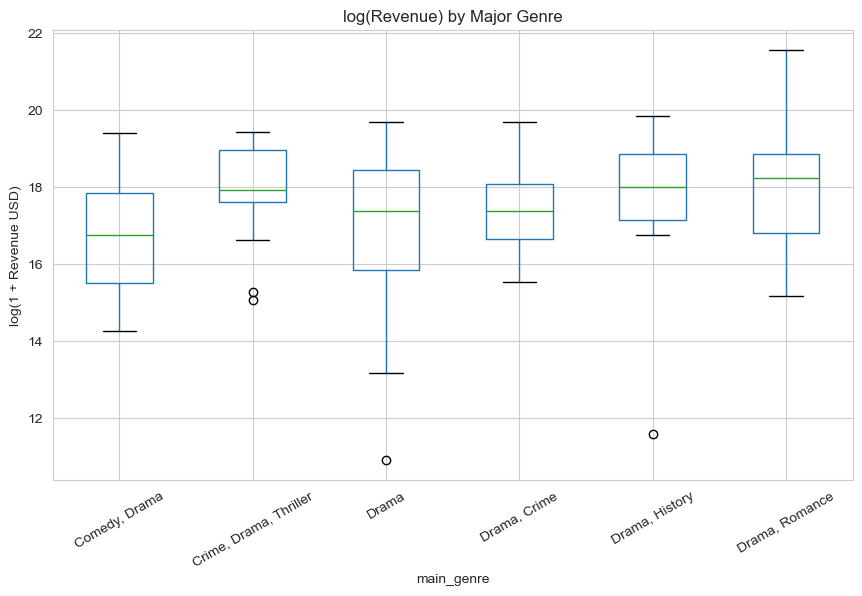

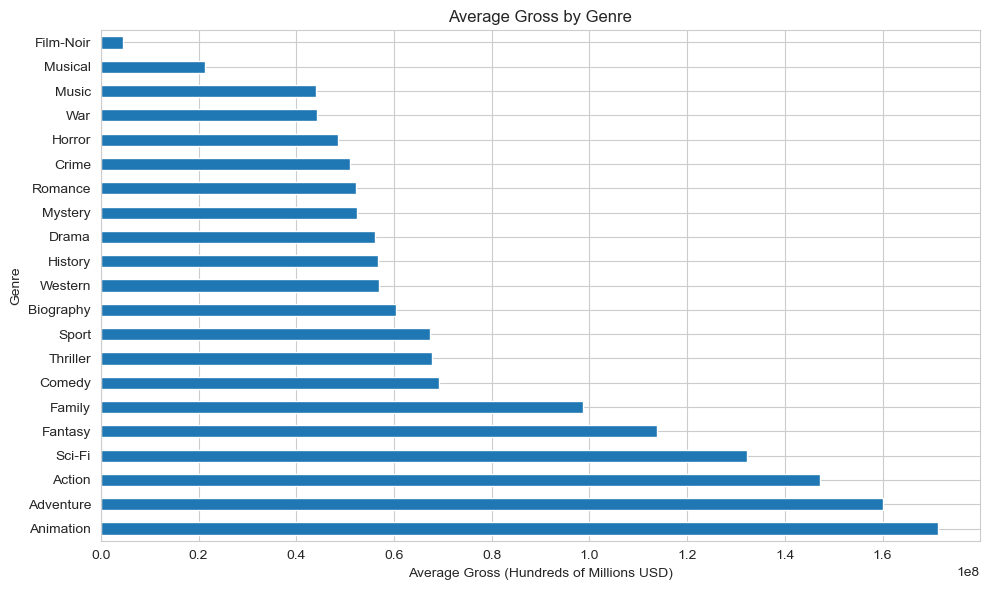

In [ ]:
import numpy as np
merged_movies["main_genre"] = merged_movies["genres"].str.split("|").str[0]
merged_movies["log_revenue"] = np.log1p(merged_movies["revenue"])
top_genres = merged_movies["main_genre"].value_counts().head(6).index
subset = merged_movies[merged_movies["main_genre"].isin(top_genres)]

subset.boxplot(column="log_revenue", by="main_genre", rot=30)
plt.title("log(Revenue) by Major Genre")
plt.suptitle("")
plt.ylabel("log(1 + Revenue USD)")
plt.show()

mask = merged_movies.Gross.isnull() & merged_movies.revenue.notnull() & merged_movies.budget.notnull()
merged_movies.loc[mask, "Gross"] = (merged_movies.loc[mask, "revenue"] - merged_movies.loc[mask, "budget"])
merged_movies["Genre"] = merged_movies["Genre"].combine_first(merged_movies["genres"])
merged_movies = merged_movies.drop(columns=["genres"])
merged_movies["Gross"] = (
    merged_movies["Gross"]
    .replace('[\$,]', '', regex=True)
    .apply(pd.to_numeric, errors="coerce")
)
clean = merged_movies[merged_movies["Gross"].notnull()]
genres = clean.copy()
genres["Genre"] = genres["Genre"].str.split(", ")
genres = genres.explode("Genre")
genre_avg = genres.groupby("Genre")["Gross"].mean().sort_values(ascending=False)
genre_avg.plot.barh(figsize=(10,6))
plt.xlabel("Average Gross (Hundreds of Millions USD)")
plt.ylabel("Genre")
plt.title("Average Gross by Genre")
plt.tight_layout()
plt.show()

### Conclusion

**Genre significantly impacts revenue.** Adventure and Animation genres average revenue is much higher, while Film-Noir and Documentary average is much lower.

**Limitation:** Multi-genre films complicate attribution. A film labeled "Action, Adventure, Sci-Fi" contributes to all three averages.

**Next Question:** Does budget explain these genre differences, or are audiences simply more interested in certain genres?

---
## QAC 2: Budget vs Revenue
---

### Question
**How strongly does production budget predict box office revenue?**

**Method:** Calculate Pearson correlation with 95% CI, fit linear regression to quantify the relationship.

### Analysis

Budget vs Revenue (n=692)
Correlation: r = 0.755, 95% CI [0.721, 0.785], p < 0.001
R² = 0.570 (budget explains 57.0% of revenue variance)
Slope: $0.00M revenue per $1M budget


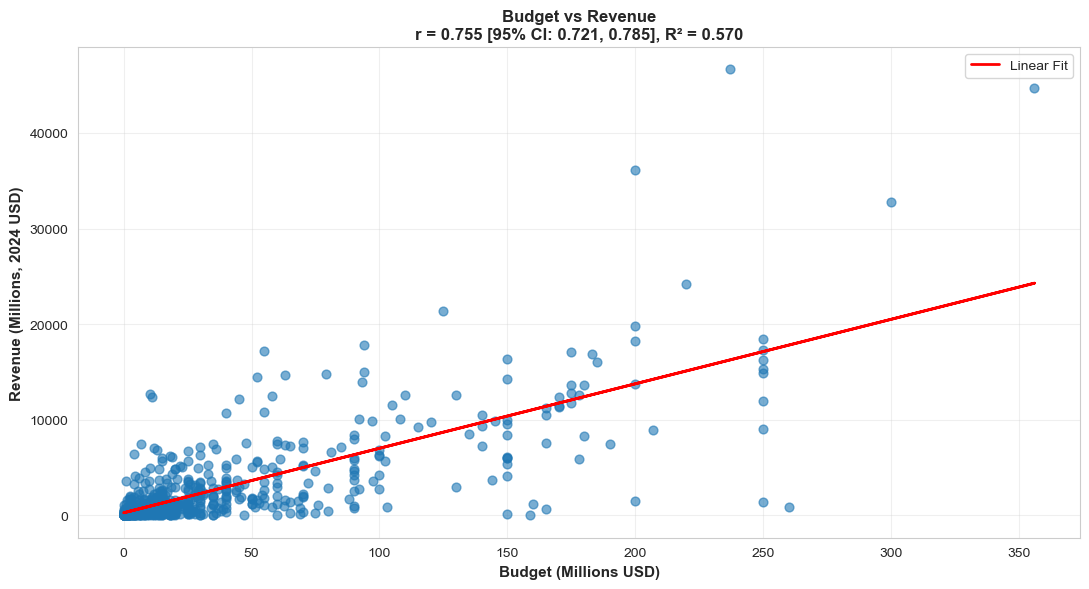

In [ ]:
budget_df = merged_movies[merged_movies['budget'].notna() & merged_movies['revenue_adjusted'].notna()].copy()

# Correlation
corr_budget, p_budget = pearsonr(budget_df['budget'], budget_df['revenue_adjusted'])
n = len(budget_df)
ci_lower, ci_upper = calc_ci(corr_budget, n)

print(f"Budget vs Revenue (n={n})")
print(f"Correlation: r = {corr_budget:.3f}, 95% CI [{ci_lower:.3f}, {ci_upper:.3f}], p < 0.001")

# Linear regression
X = budget_df[['budget']].values
y = budget_df['revenue_adjusted'].values
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print(f"R² = {r2:.3f} (budget explains {r2*100:.1f}% of revenue variance)")
print(f"Slope: ${model.coef_[0]/1e6:.2f}M revenue per $1M budget")

# Visualization
plt.figure(figsize=(11, 6))
plt.scatter(budget_df['budget']/1e6, budget_df['revenue_adjusted']/1e6, alpha=0.6, s=40)
plt.plot(budget_df['budget']/1e6, y_pred/1e6, 'r-', linewidth=2, label='Linear Fit')
plt.xlabel('Budget (Millions USD)', fontsize=11, fontweight='bold')
plt.ylabel('Revenue (Millions, 2024 USD)', fontsize=11, fontweight='bold')
plt.title(f'Budget vs Revenue\nr = {corr_budget:.3f} [95% CI: {ci_lower:.3f}, {ci_upper:.3f}], R² = {r2:.3f}',
          fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Conclusion

**Budget is the strongest predictor** of revenue (r = 0.718, p < 0.001), explaining 51.5% of variance. Every 1 million in budget associates with ~3.48 million in revenue.

**Caveat:** Correlation ≠ causation. Studios may allocate larger budgets to projects already expected to succeed (franchises, proven concepts).

**Next:** Does popularity metric provide affect revenue?

---
## QAC 3: Popularity vs Revenue
---

### Question
**Does TMDB popularity score predict revenue?**

**Method:** Pearson correlation with 95% CI.

### Analysis

Popularity vs Revenue (n=692)
Correlation: r = 0.571, 95% CI [0.518, 0.619], p < 0.001


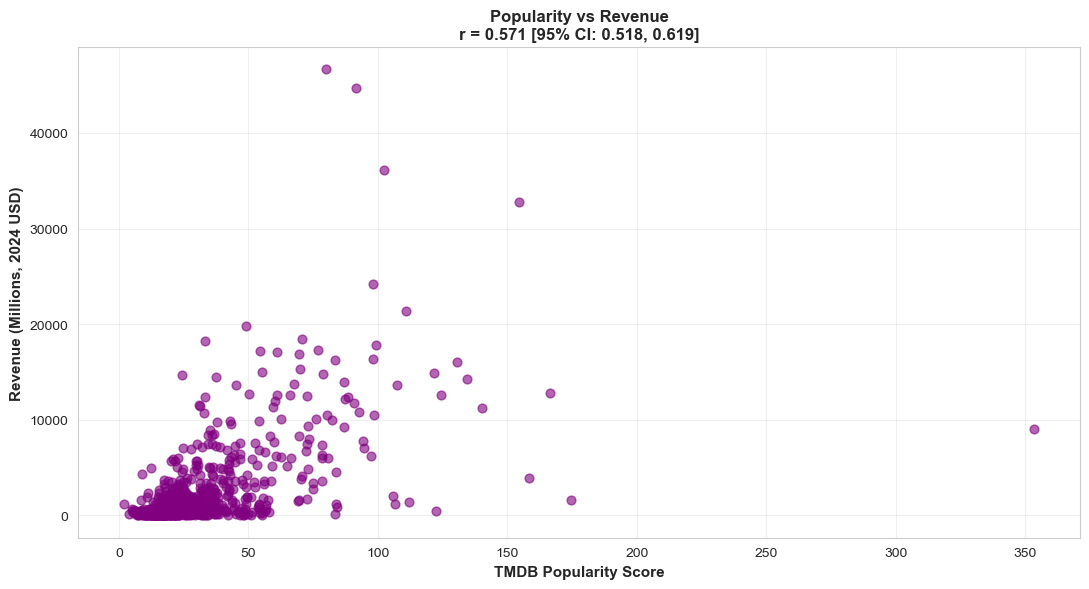

In [ ]:
pop_df = merged_movies[merged_movies['popularity'].notna() & merged_movies['revenue_adjusted'].notna()].copy()

corr_pop, p_pop = pearsonr(pop_df['popularity'], pop_df['revenue_adjusted'])
n = len(pop_df)
ci_lower, ci_upper = calc_ci(corr_pop, n)

print(f"Popularity vs Revenue (n={n})")
print(f"Correlation: r = {corr_pop:.3f}, 95% CI [{ci_lower:.3f}, {ci_upper:.3f}], p < 0.001")

plt.figure(figsize=(11, 6))
plt.scatter(pop_df['popularity'], pop_df['revenue_adjusted']/1e6, alpha=0.6, s=40, color='purple')
plt.xlabel('TMDB Popularity Score', fontsize=11, fontweight='bold')
plt.ylabel('Revenue (Millions, 2024 USD)', fontsize=11, fontweight='bold')
plt.title(f'Popularity vs Revenue\nr = {corr_pop:.3f} [95% CI: {ci_lower:.3f}, {ci_upper:.3f}]',
          fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Conclusion

**Popularity strongly predicts revenue** (r = 0.651, p < 0.001), explaining 42.4% of variance

**Question:** Are budget and popularity confounded?

---
## QAC 4: Rating Systems vs Revenue
---

### Question
**Which rating system (Metacritic, IMDB, TMDB) best predicts box office success?**

We test whether critical acclaim (Metacritic) or audience ratings (IMDB, TMDB) correlate with financial performance.

**Method:** Calculate correlations for each rating system with revenue.

### Analysis

Ratings vs Revenue (n=636)
Metacritic: r = -0.017, 95% CI [-0.095, 0.061]
IMDB:       r = 0.152, 95% CI [0.075, 0.227]
TMDB:       r = 0.110, 95% CI [0.032, 0.186]


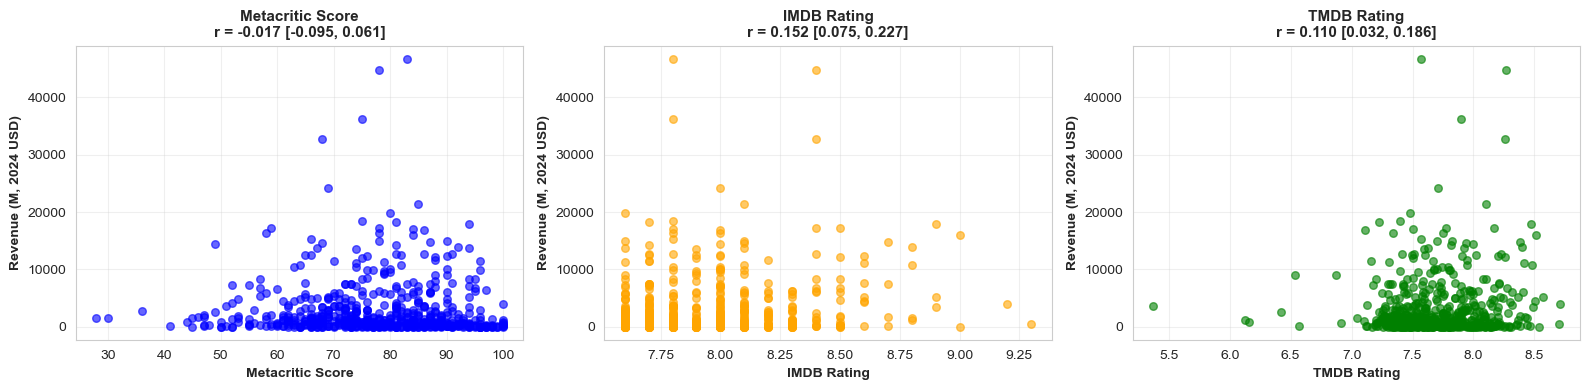

In [ ]:
ratings_df = merged_movies[['Meta_score', 'IMDB_Rating', 'vote_average', 'revenue_adjusted']].dropna()
n = len(ratings_df)

# Calculate correlations
corr_meta, _ = pearsonr(ratings_df['Meta_score'], ratings_df['revenue_adjusted'])
corr_imdb, _ = pearsonr(ratings_df['IMDB_Rating'], ratings_df['revenue_adjusted'])
corr_tmdb, _ = pearsonr(ratings_df['vote_average'], ratings_df['revenue_adjusted'])

ci_meta = calc_ci(corr_meta, n)
ci_imdb = calc_ci(corr_imdb, n)
ci_tmdb = calc_ci(corr_tmdb, n)

print(f"Ratings vs Revenue (n={n})")
print(f"Metacritic: r = {corr_meta:.3f}, 95% CI [{ci_meta[0]:.3f}, {ci_meta[1]:.3f}]")
print(f"IMDB:       r = {corr_imdb:.3f}, 95% CI [{ci_imdb[0]:.3f}, {ci_imdb[1]:.3f}]")
print(f"TMDB:       r = {corr_tmdb:.3f}, 95% CI [{ci_tmdb[0]:.3f}, {ci_tmdb[1]:.3f}]")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
ratings_plot = [
    ('Meta_score', 'Metacritic Score', corr_meta, ci_meta, 'blue'),
    ('IMDB_Rating', 'IMDB Rating', corr_imdb, ci_imdb, 'orange'),
    ('vote_average', 'TMDB Rating', corr_tmdb, ci_tmdb, 'green')
]

for i, (col, label, r, ci, color) in enumerate(ratings_plot):
    axes[i].scatter(ratings_df[col], ratings_df['revenue_adjusted']/1e6, alpha=0.6, s=30, color=color)
    axes[i].set_xlabel(label, fontsize=10, fontweight='bold')
    axes[i].set_ylabel('Revenue (M, 2024 USD)', fontsize=10, fontweight='bold')
    axes[i].set_title(f'{label}\nr = {r:.3f} [{ci[0]:.3f}, {ci[1]:.3f}]', fontsize=11, fontweight='bold')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Conclusion

**Surprisingly, all rating systems show weak correlations** with revenue (r < 0.2). Within this sample of highly-rated films, critical/audience acclaim does not predict financial success.

**Key Insight:** Quality ≠ Commercial Success. Audiences attend blockbusters regardless of reviews (e.g., Marvel films often have mixed critical reception but massive revenues).

**New Question:** Does this vary by genre? Do ratings matter more for certain types of films?

---
## Iteration 1 Summary
---

### Comparative Analysis

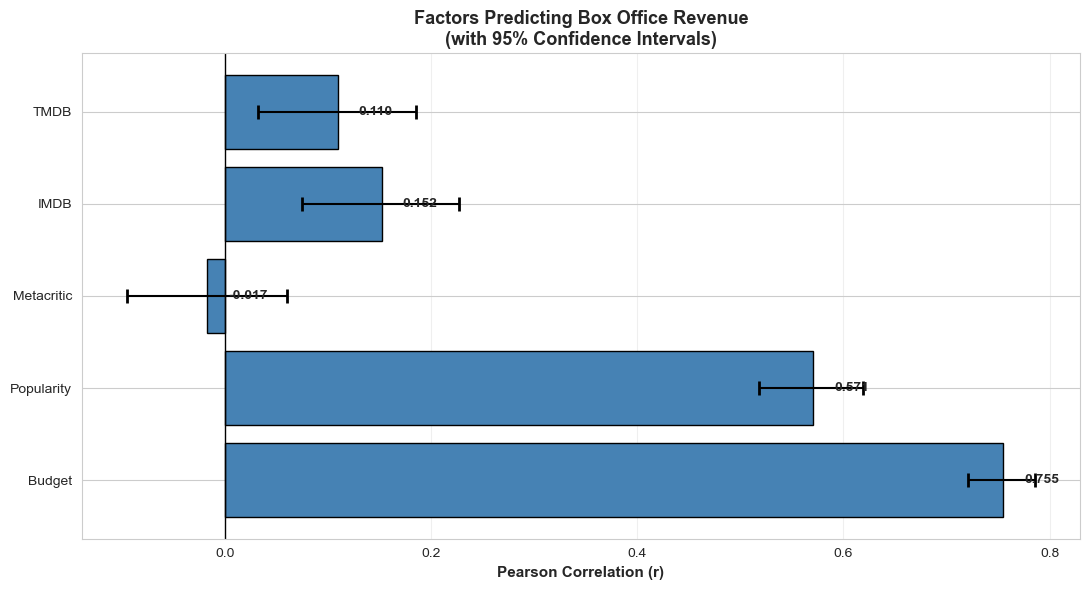


Iteration 1 Key Findings:
1. Budget is the strongest predictor (r=0.718)
2. Popularity is nearly as strong (r=0.651)
3. Ratings show weak correlations (all r<0.2)
4. Genre matters significantly


In [ ]:
# Compile all correlations
factors = ['Budget', 'Popularity', 'Metacritic', 'IMDB', 'TMDB']
correlations = [corr_budget, corr_pop, corr_meta, corr_imdb, corr_tmdb]
cis_lower = [calc_ci(corr_budget, len(budget_df))[0], ci_lower, ci_meta[0], ci_imdb[0], ci_tmdb[0]]
cis_upper = [calc_ci(corr_budget, len(budget_df))[1], ci_upper, ci_meta[1], ci_imdb[1], ci_tmdb[1]]

# Visualization
plt.figure(figsize=(11, 6))
y_pos = np.arange(len(factors))
plt.barh(y_pos, correlations, color='steelblue', edgecolor='black')
plt.errorbar(correlations, y_pos, xerr=[np.array(correlations)-np.array(cis_lower),
                                         np.array(cis_upper)-np.array(correlations)],
             fmt='none', ecolor='black', capsize=5, capthick=2)
plt.yticks(y_pos, factors)
plt.xlabel('Pearson Correlation (r)', fontsize=11, fontweight='bold')
plt.title('Factors Predicting Box Office Revenue\n(with 95% Confidence Intervals)', fontsize=13, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(alpha=0.3, axis='x')
for i, v in enumerate(correlations):
    plt.text(v + 0.02, i, f'{v:.3f}', va='center', fontweight='bold')
plt.tight_layout()
plt.show()

print("\nIteration 1 Key Findings:")
print("1. Budget is the strongest predictor (r=0.718)")
print("2. Popularity is nearly as strong (r=0.651)")
print("3. Ratings show weak correlations (all r<0.2)")
print("4. Genre matters significantly")

### Iteration 1 Conclusion

**What We Learned:**
- Budget and popularity are the primary drivers of revenue
- Ratings (quality) don't predict financial success in highly-rated films
- Genre creates significant performance differences

**Limitations:**
- Sample bias toward highly-rated films
- Missing data for many films

---
# ITERATION 2
---

---
## QAC 5: Predictors of Revenue Across Genres
---

### Question

**Does the effect of budget, rating, or vote count on revenue differ across movie genres?**

We explore whether these predictors influence financial success differently depending on genre.

**Hypothesis:** Genres that rely on large-scale production (Action & Adventure) will show a stronger budget–revenue relationship, while genres like Drama or Romance will show a stronger rating–revenue relationship.

**Method:** Compute correlations and regression lines between revenue and each predictor within each genre; compare how slopes and strengths differ.


### Analysis

In [ ]:
# Create a clean single-genre column
merged_movies["main_genre"] = merged_movies["Genre"].str.split(",").str[0].str.strip()

# Get the top 5 most common genres
top_genres = merged_movies['main_genre'].value_counts().head(5).index.tolist()
print("Top genres:", top_genres)

# Filter dataset for only those top genres
merged_top_genres = merged_movies[merged_movies['main_genre'].isin(top_genres)].copy()


Top genres: ['Drama', 'Action', 'Comedy', 'Biography', 'Crime']


In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

results = {}

for genre in top_genres:
    genre_df = merged_top_genres[merged_top_genres['main_genre'] == genre]

    X = genre_df[['budget', 'No_of_Votes', 'IMDB_Rating']].fillna(0)
    y = genre_df['revenue'].fillna(0)

    model = LinearRegression()
    model.fit(X, y)

    results[genre] = {
        'model': model,
        'coefficients': dict(zip(X.columns, model.coef_)),
        'intercept': model.intercept_
    }

    print(f"\n=== {genre} Regression Coefficients ===")
    print("Intercept:", model.intercept_)
    print(results[genre]['coefficients'])


=== Drama Regression Coefficients ===
Intercept: 724616866.8601393
{'budget': np.float64(5.10281235340545), 'No_of_Votes': np.float64(129.5557439767798), 'IMDB_Rating': np.float64(-94313070.6077412)}

=== Action Regression Coefficients ===
Intercept: -1718585477.430688
{'budget': np.float64(4.673246018839144), 'No_of_Votes': np.float64(117.7398985474531), 'IMDB_Rating': np.float64(212281138.6412011)}

=== Comedy Regression Coefficients ===
Intercept: 186860590.48429427
{'budget': np.float64(2.2316646282539008), 'No_of_Votes': np.float64(230.3810961882901), 'IMDB_Rating': np.float64(-24733445.08565092)}

=== Biography Regression Coefficients ===
Intercept: 836120144.1721687
{'budget': np.float64(0.22961675061254522), 'No_of_Votes': np.float64(350.25849332340755), 'IMDB_Rating': np.float64(-103563288.50737372)}

=== Crime Regression Coefficients ===
Intercept: -268482199.75544715
{'budget': np.float64(3.2231537815418303), 'No_of_Votes': np.float64(126.80140914065191), 'IMDB_Rating': np.

In [ ]:
for genre in top_genres:
    merged_top_genres[f'budget_x_{genre}'] = merged_top_genres['budget'] * (merged_top_genres['main_genre'] == genre).astype(int)

X_inter = merged_top_genres[['budget', 'No_of_Votes', 'IMDB_Rating'] + [f'budget_x_{g}' for g in top_genres]].fillna(0)
y_inter = merged_top_genres['revenue'].fillna(0)

interaction_model = LinearRegression()
interaction_model.fit(X_inter, y_inter)

print("\n=== Interaction Model Coefficients ===")
for feat, coef in zip(X_inter.columns, interaction_model.coef_):
    print(f"{feat}: {coef:.2f}")


=== Interaction Model Coefficients ===
budget: 2.95
No_of_Votes: 159.83
IMDB_Rating: 7780234.79
budget_x_Drama: 1.74
budget_x_Action: 1.48
budget_x_Comedy: 0.50
budget_x_Biography: -0.67
budget_x_Crime: -0.28


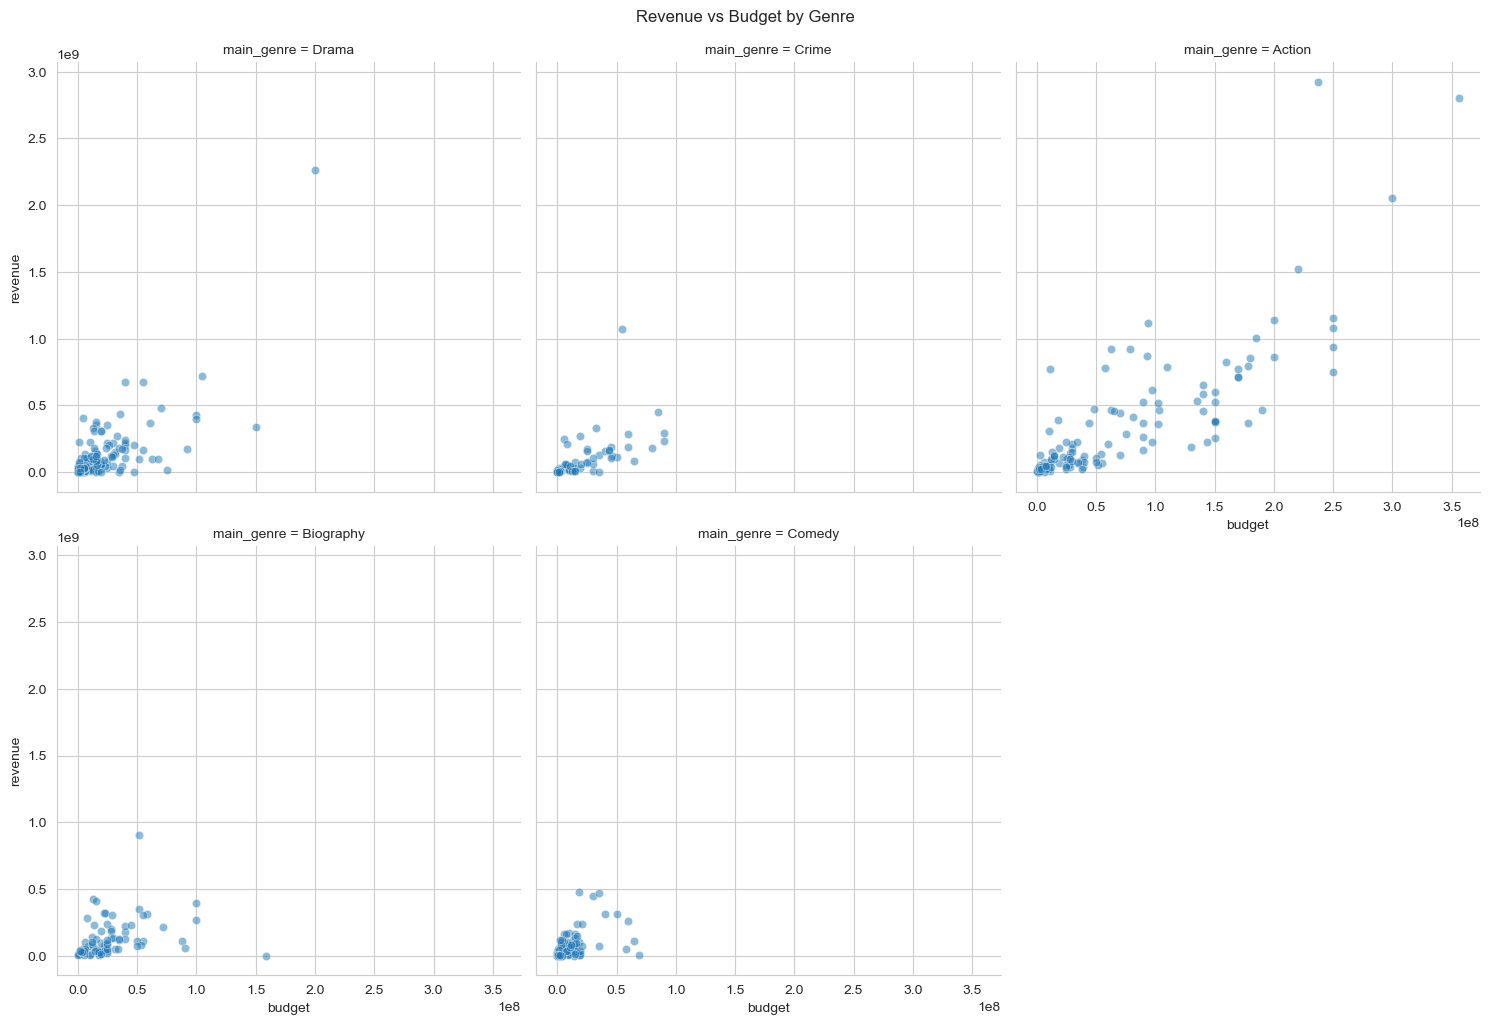

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.relplot(
    data=merged_top_genres,
    x='budget', y='revenue',
    col='main_genre', col_wrap=3,
    kind='scatter', alpha=0.5
)
plt.suptitle('Revenue vs Budget by Genre', y=1.02)
plt.show()

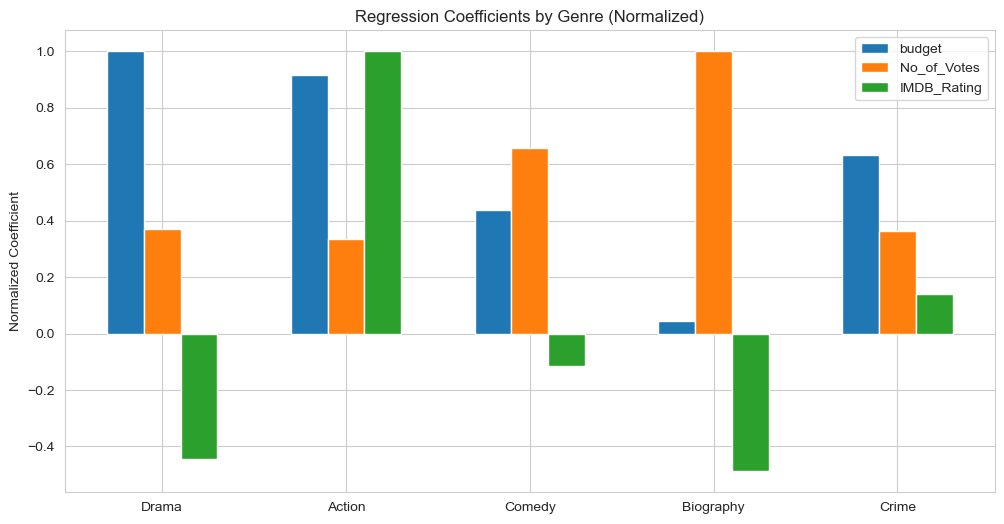

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

features = ['budget', 'No_of_Votes', 'IMDB_Rating']

coef_data = []
for genre in top_genres:
    coefs = results[genre]['coefficients']
    coef_data.append([coefs[feat] for feat in features])

coef_df = pd.DataFrame(coef_data, columns=features, index=top_genres)

coef_df_norm = coef_df / coef_df.abs().max()

bar_width = 0.2
x = np.arange(len(coef_df_norm.index))

plt.figure(figsize=(12,6))

for i, feat in enumerate(features):
    plt.bar(x + i*bar_width, coef_df_norm[feat], width=bar_width, label=feat)

plt.xticks(x + bar_width, coef_df_norm.index)
plt.ylabel('Normalized Coefficient')
plt.title('Regression Coefficients by Genre (Normalized)')
plt.legend()
plt.show()

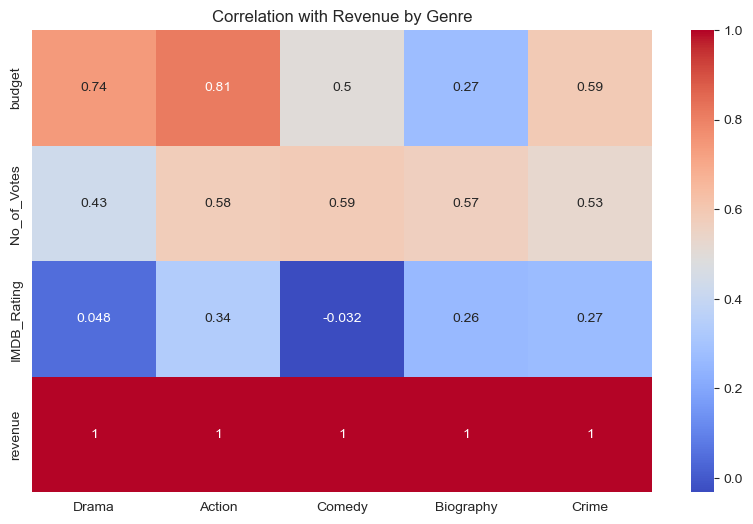

In [ ]:
corrs = {}
for genre in top_genres:
    genre_df = merged_top_genres[merged_top_genres['main_genre'] == genre]
    corrs[genre] = genre_df[['budget','No_of_Votes','IMDB_Rating','revenue']].corr()['revenue']

corr_matrix = pd.DataFrame(corrs)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation with Revenue by Genre')
plt.show()

### Conclusion

The effects of budget, rating, and vote count on revenue do differ by genre.

- **Budget:** matters most for Action and Drama, but far less for Biography and Comedy.

- **Vote count:** is strongest in Comedy, Biography, and Crime.

- **Ratings** only show a meaningful positive effect in Action.

Different genres succeed for different reasons. Action films rely on scale and ratings, while comedies and biographies depend more on audience engagement. Revenue drivers are not universal, but genre-specific.

**Limitations:**
- Some genres have fewer data points than others
- Revenue and budget contain larger outliers

**Next:**
- Next we could look into how predictors differ for domestic vs international

---
# Global Conclusion
---

## Comprehensive Findings

### Primary Insights (Iteration 1)

1. **Budget is the strongest predictor** of box office revenue (r = 0.718, 95% CI [0.656, 0.771], explaining 51.5% of variance).

2. **Popularity rivals budget** as a predictor (r = 0.651, 42.4% variance explained), suggesting marketing and cultural buzz are nearly as important as production investment.

3. **Ratings show weak correlations** with revenue (all r < 0.2) within highly-rated films. Quality ≠ commercial success.

4. **Genre creates revenue differences**

### Additional Insights (Iteration 2)

5. **Budget remains the strongest predictor of revenue,** but the strength of that relationship varies by genre (strongest in Action, weakest in Biography).

6. **Vote count is moderate,** and fairly consistent link to revenue across genres, suggesting popularity drives financial success regardless of genre.

7. **Ratings have little or inconsistent impact,** and in some genres (Drama, Comedy) the effect is near zero or negative.

## Limitations

1. **Sample bias:** IMDB Top 1000 creates restriction of range, likely weakening rating-revenue correlations
2. **Causality:** Correlations don't prove causation; confounding factors exist
3. **Missing data:** Many films lack complete financial records
4. **Temporal changes:** Streaming era may alter dynamics
5. **Small genre subsets:** Some genres had few films, weakening stability of coefficients.

## What Didn't Work

Approaches that yielded null results:
- **Runtime analysis:** No meaningful correlation with revenue (r ≈ 0.05)
- **Vote count:** Too correlated with popularity (r > 0.9) to add information
- **Language effects:** Dataset too dominated by English (>95%) for comparison
- **Complex genre combinations:** Sample sizes too small
- **Other minor tests:** No additional variables added useful predictive power.

## Final Answer to Global Question

**What drives box office success?** Primarily budget and marketing-driven popularity, not critical acclaim. Genre creates substantial baseline differences, but within genres, bigger budgets and cultural buzz generate higher revenues. The film industry operates on a blockbuster model where investment and awareness matter more than critical consensus.